<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png" alt="alt text" width="400" height="100">

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class TwoClassData(Dataset):
    def __init__(self, num_datapoints):
        # Define the mean and covariance for two random data distributions
        class_1_cov = torch.FloatTensor([[1.0, 0.25], [0.25, 1.4]])
        class_1_mu = torch.FloatTensor([[1, -1.5]])

        class_2_cov = torch.FloatTensor([[2, -0.5], [-0.5, 1]])
        class_2_mu = torch.FloatTensor([[-2, -3]])

        # Randomly Create the two data distributions
        class_1_data = torch.randn(num_datapoints, 2)
        class_1_data = torch.mm(class_1_data, class_1_cov) + class_1_mu

        class_2_data = torch.randn(num_datapoints, 2)
        class_2_data = torch.mm(class_2_data, class_2_cov) + class_2_mu

        class_1_labels = torch.zeros(num_datapoints, 1)
        class_2_labels = torch.ones(num_datapoints, 1)

        self.data = torch.cat((class_1_data, class_2_data), 0)
        self.labels = torch.cat((class_1_labels, class_2_labels), 0)

        self.num_datapoints = num_datapoints

    def __getitem__(self, index):
        # This function is called by the dataLOADER class whenever it wants a new mini-batch
        # The dataLOADER class will pass the dataSET and number of datapoint indexes (mini-batch of indexes)
        # It is up to the dataSET's __getitem__ function to output the corresponding input datapoints
        # AND the corresponding labels
        # It is important to know that the input "index" is a single Python int, therefore the
        # output of __getitem__ is a SINGLE datapoint with NO "batch dimension"

        return self.data[index], self.labels[index]
        # Note:Pytorch will actually pass the __getitem__ function one index at a time
        # If use multiple dataLOADER "workers" multiple __getitem__ calls will be made in parallel
        # (Pytorch will spawn multiple processes - usually not necessary for simple datasets, it is 0 by default)
        # WARNING having workers > 0 on Window OS is buggy, so if using Windows and the dataLOADER gets
        # stuck, make sure workers=0

    def __len__(self):
        # Specify a "length" function, Python will use this fuction whenever
        # use the Python len(function) on the dataset
        # Define it so the dataLOADER knows how big the dataSET is!
        return 2 * self.num_datapoints

In [4]:
num_training_data = 1000
num_validation_data = 500
num_test_data = 200

batch_size = 200

#Create an instance of TwoClassData for the training and validation and test set
dataset_train = TwoClassData(num_training_data)
dataset_val = TwoClassData(num_validation_data)
dataset_test  = TwoClassData(num_test_data)

#Now pass the dataSET to the Pytorch dataLOADER class along with some other arguments
#batch_size - the size of the mini-batches
#shuffle - whether or not shuffle the dataset
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
data_loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

The DataSET class is used by the DataLOADER to interface with the dataset, once pass it to the DataLoader rarely need to interact with it directly.

In [5]:
# The length of the dataset with be whatever returned in the __len__ method
print("Train DataSET size:", len(dataset_train))
print("Val DataSET size:", len(dataset_val))
print("Test DataSET size:", len(dataset_test))

Train DataSET size: 2000
Val DataSET size: 1000
Test DataSET size: 400


In [6]:
# The length of the dataLOADER is the length of the dataSET divided by the batchsize!
# it is the number of loops need to do per epoch.
# If the length of the dataSET is not perfectly divisible by the batch size the DataLOADER will simply return the
# "leftovers" in the last iteration, so the batch size of the last iteration might not equal the batch size!!
# If simply skip this "uneven" batch, set the flag "drop_last" to True
# when creating the DataLOADER
print("Train DataLOADER size:", len(data_loader_train))
print("Val DataLOADER size:", len(data_loader_val))
print("Test DataLOADER size:", len(data_loader_test))
# Note: A larger batch size means less noisy gradients, but fewer gradient steps per epoch!

Train DataLOADER size: 10
Val DataLOADER size: 5
Test DataLOADER size: 2


In [7]:
# The DataLOADER will loop through a batch of indices and provide them to the dataSET one at a time
# and will "batch" together all the datapoints along the "batch dimension" (dim 0) returning a single tensor
train_data_iter = iter(data_loader_train)
data, labels = next(train_data_iter)
print("Input Data shape", data.shape)
print("Target Data shape", labels.shape)

Input Data shape torch.Size([200, 2])
Target Data shape torch.Size([200, 1])


In [8]:
# These functions/methods do not change from before!
def training_step(data_batch, target_batch, model, optimizer, loss_func):
    target_pred = model(data_batch)
    loss = loss_func(target_pred, target_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def eval_step(data_batch, target_batch, model):
    with torch.no_grad():
        target_pred = model(data_batch)
        predictions = (target_pred >= 0)

        num_correct = (predictions == target_batch).sum()

        return num_correct.item()

In [9]:
# Function to calulate the accuracy of the model for the given data and labels!
def eval_loop(eval_dataloader, model):
    total_correct = 0

    # All need to do now is loop over the data loader
    for data, target in eval_dataloader:
        num_correct = eval_step(data, target, model)
        total_correct += num_correct

    return total_correct/len(eval_dataloader.dataset)


# Function to perform the training loop
def training_loop(train_dataloader, val_dataloader, model, optimizer, loss_func, num_epochs):

    loss_logger = []
    val_accuracy_logger = []
    train_accuracy_logger = []

    # A single loop over the whole dataset is called an "epoch"
    for epoch in range(num_epochs):
        val_acc = eval_loop(val_dataloader, model)
        val_accuracy_logger.append(val_acc)

        train_acc = eval_loop(train_dataloader, model)
        train_accuracy_logger.append(train_acc)

        # All need to do now is loop over the data loader
        for data, target in train_dataloader:
            # Loop over the mini batches and perform a step of gradient decent every time
            loss = training_step(data, target, model, optimizer, loss_func)
            loss_logger.append(loss)

    return loss_logger, train_accuracy_logger, val_accuracy_logger

In [10]:
linear = nn.Linear(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.001)
num_epochs = 400

In [11]:
start_time = time.time()
loss_logger, train_acc, val_acc = training_loop(data_loader_train, data_loader_val, linear, optimizer,
                                                loss_function, num_epochs=num_epochs)

print("Traing for %d epochs with a batch size of %d took %.2f seconds" %
      (num_epochs, batch_size, time.time() - start_time))

Traing for 400 epochs with a batch size of 200 took 17.56 seconds


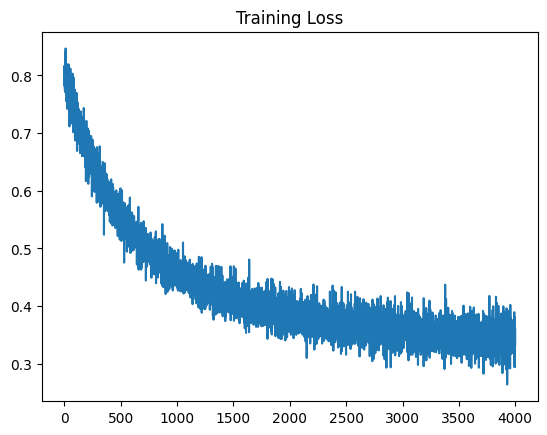

In [12]:
plt.plot(loss_logger)
_ = plt.title("Training Loss")

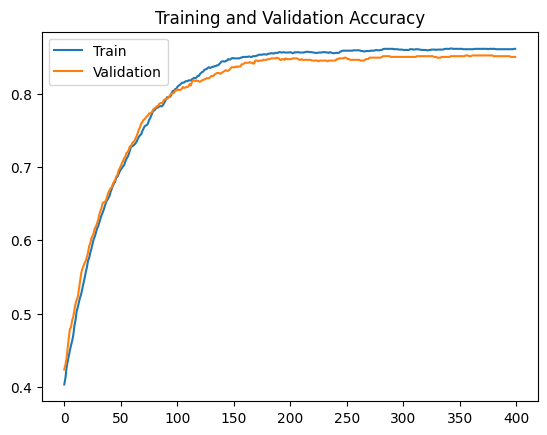

In [13]:
plt.plot(train_acc)
plt.plot(val_acc)
_ = plt.title("Training and Validation Accuracy")
plt.legend(["Train", "Validation"])

In [14]:
test_accuracy = eval_loop(data_loader_test, linear)
print("Test Accuracy is %.2f%%" % (100 * test_accuracy))

Test Accuracy is 86.50%
